# Sketch Based Image Recognition

In [ ]:
f = open("categories.txt","r")
classes = f.readlines()
f.close()

In [ ]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the Dataset 

In [ ]:
!mkdir Data

In [ ]:
import urllib.request
def download():
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in classes:        
        cls_url = c.replace('_', '%20')
        path = base+cls_url+'.npy'
        print(path)
        urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [ ]:
download()

# Imports

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from random import randint

# Load data

In [2]:


def load_data(root, vfold_ratio=0.2, max_items_per_class=4000):
    
    all_files = glob.glob(os.path.join(root, '*.npy'))
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []
    
    # Load each data file
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0:max_items_per_class, :]
        labels = np.full(data.shape[0], idx)
        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)
        class_name, _ = os.path.splitext(os.path.basename(file))
        class_names.append(class_name.replace('full_numpy_bitmap_','').title())
    
    # Randomize the dataset
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]
    
    # Split into training and testing
    vfold_size = int(x.shape[0] * vfold_ratio)
    x_test = x[:vfold_size, :]
    y_test = y[:vfold_size]
    x_train = x[vfold_size:, :]
    y_train = y[vfold_size:]
    
    return x_train, y_train, x_test, y_test, class_names

In [7]:
x_train, y_train, x_test, y_test, class_names = load_data(r"Data")
num_classes = len(class_names)

# Preprocess the Data 

In [3]:


def preprocess_data(x_train, x_test, y_train, y_test, num_classes, image_size=28):
    
    # Reshape and normalize
    x_train = x_train.reshape(-1, image_size, image_size, 1).astype('float32') / 255.0
    x_test = x_test.reshape(-1, image_size, image_size, 1).astype('float32') / 255.0
    
    # Convert to categorical
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    return x_train, x_test, y_train, y_test


In [16]:
x_train, x_test, y_train, y_test = preprocess_data(
        x_train, x_test, y_train, y_test, num_classes
    )

# Model

In [4]:

def create_model(input_shape, num_classes):

    model = keras.Sequential([

        layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Flatten(),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [17]:
model = create_model(x_train.shape[1:], num_classes)
model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

c:\Users\sbhar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         6,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,050 (406.45 KB)

 Trainable params: 103,826 (405.57 KB)

 Non-trainable params: 224 (896.00 B)

In [19]:
callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2
        )
    ]

# Training

In [30]:
model.fit(
        x_train,
        y_train,
        batch_size=256,
        epochs=10,
        validation_split=0.1,
        callbacks=callbacks,
        verbose=1
    )

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.7250 - loss: 0.9990 - val_accuracy: 0.7984 - val_loss: 0.7342 - learning_rate: 0.0010
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - accuracy: 0.7768 - loss: 0.8125 - val_accuracy: 0.8190 - val_loss: 0.6650 - learning_rate: 0.0010
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 45s 80ms/step - accuracy: 0.7976 - loss: 0.7356 - val_accuracy: 0.8393 - val_loss: 0.6020 - learning_rate: 0.0010
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.8158 - loss: 0.6736 - val_accuracy: 0.8431 - val_loss: 0.5753 - learning_rate: 0.0010
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 51s 91ms/step - accuracy: 0.8256 - loss: 0.6308 - val_accuracy: 0.8471 - val_loss: 0.5537 - learning_rate: 0.0010
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 52s 93ms/step - accuracy: 0.8323 - loss: 0.6037 - val_accuracy: 0.8526 - val_loss: 0.5391 - learning_rate: 0.0010
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 53s 95ms/step - accuracy: 0.8388 - l

# Testing

In [31]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f'\nTest accuracy: {test_acc*100:.2f}%')


Test accuracy: 85.66%


# Image visualization

In [5]:
def plot_sample(x_data, y_true, class_names, title="Sample Image"):
    idx = randint(0, len(x_data))
    plt.figure(figsize=(4, 4))
    plt.imshow(x_data[idx].reshape(28, 28), cmap='gray')
    plt.title(f"{title}\nClass: {class_names[int(y_true[idx])]}")
    plt.axis('off')
    plt.show()

# Prediction

In [32]:
def predict_drawing(image, top_k=5):
        pred = model.predict(np.expand_dims(image, axis=0))[0]
        top_indices = (-pred).argsort()[:top_k]
        return [class_names[i] for i in top_indices]

In [34]:
str(class_names)

"['Airplane', 'Alarm Clock', 'Apple', 'Banana', 'Basketball', 'Car', 'Carrot', 'Cat', 'Circle', 'Clock', 'Cloud', 'Cooler', 'Eye', 'Fish', 'Flower', 'Fork', 'Grapes', 'Grass', 'Hammer', 'Headphones', 'Helicopter', 'Hexagon', 'Hot Air Balloon', 'House', 'Key', 'Knife', 'Ladder', 'Octagon', 'Onion', 'Palm Tree', 'Pants', 'Peanut', 'Pencil', 'Pizza', 'Rain', 'Rainbow', 'Smiley Face', 'Snake', 'Soccer Ball', 'Square', 'Star', 'Sun', 'Tooth', 'Toothbrush', 'Toothpaste', 'Traffic Light', 'Tree', 'Triangle', 'Truck', 'Umbrella']"

Actual : [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


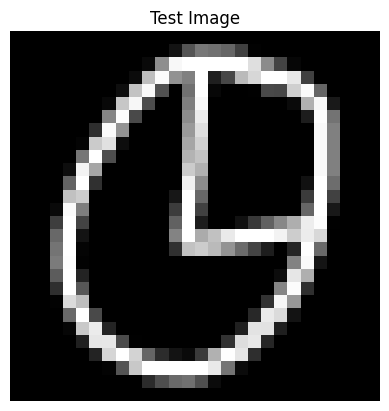

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Top 5 predictions: ['Clock', 'Smiley Face', 'Basketball', 'Soccer Ball', 'Circle']


numpy.ndarray

In [57]:
# Show sample prediction
idx = randint(0, len(x_test))
test_image = x_test[idx]

plt.imshow(test_image.squeeze(), cmap='gray')
plt.axis('off')
plt.title("Test Image")
plt.show()

predictions = predict_drawing(test_image)
print("\nTop 5 predictions:", predictions)


# Model save

In [58]:
model.save("model50.keras")